In [1]:
import os.path as path
from dataclasses import dataclass
import json
import os

import torch as t
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import sklearn.preprocessing as skprep

import torchutils as tu
from torchutils.ml_loggers.csv_logger import CsvMLExperiment
from torchutils.ml_loggers.stdout_logger import StdoutMLExperiment
from torchutils.visualizers.csv_metrics_visualizer import compare, analyze

import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from haikunator import Haikunator

# Prep Dataset
Get rid of the color feature. According to the discussion forums that helps.

In [2]:
DATAROOT = path.expanduser("~/mldata/ghosts")

In [3]:
ghosts_df = pd.read_csv(path.join(DATAROOT, "train.csv"), index_col="id")

In [4]:
X = ghosts_df[["bone_length", "rotting_flesh", "hair_length", "has_soul"]].values
print(X.shape, X.dtype)
X[:3]

(371, 4) float64


array([[0.35451218, 0.35083903, 0.46576089, 0.78114167],
       [0.57555991, 0.42586843, 0.53140138, 0.43989888],
       [0.4678755 , 0.35433042, 0.81161609, 0.79122497]])

In [5]:
type_encoder = skprep.LabelEncoder()
type_encoder.fit(ghosts_df["type"])
type_encoder.classes_

array(['Ghost', 'Ghoul', 'Goblin'], dtype=object)

In [6]:
y = type_encoder.transform(ghosts_df["type"])
print(y.shape)
y[:5]

(371,)


array([1, 2, 1, 1, 0])

In [7]:
dataset = TensorDataset(t.from_numpy(X).to(t.float32), t.from_numpy(y).to(t.int64))

In [8]:
train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, (train_size, val_size))
print(len(trainset), len(valset))

333 38


# Train Model

In [9]:
h = Haikunator()

In [10]:
@dataclass
class MyHyperparams(tu.Hyperparams):
    batch_size: int
    n_epochs: int
    lr: float
    classifier: int

In [17]:
class BaselineClassifier(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = t.nn.Linear(4, 3)
        
    def forward(self, batch_x):
        batch_y_hat = self.fc1(batch_x)
        return batch_y_hat
    

class Perceptron(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = t.nn.Linear(4, 8)
        self.fc2 = t.nn.Linear(8, 3)
        
    def forward(self, batch_x):
        x1 = F.relu(self.fc1(batch_x))
        batch_y_hat = self.fc2(x1)
        return batch_y_hat
    
    
class MultiLayerPerceptron(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = t.nn.Linear(4, 8)
        self.fc2 = t.nn.Linear(8, 8)
        self.fc3 = t.nn.Linear(8, 3)
        
    def forward(self, batch_x):
        x1 = F.relu(self.fc1(batch_x))
        x2 = F.relu(self.fc2(x1))
        batch_y_hat = self.fc3(x2)
        return batch_y_hat
    
    
class WidePerceptron(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = t.nn.Linear(4, 100)
        self.fc2 = t.nn.Linear(100, 3)
        
    def forward(self, batch_x):
        x1 = F.relu(self.fc1(batch_x))
        batch_y_hat = self.fc2(x1)
        return batch_y_hat
        
        
class WiderPerceptron(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = t.nn.Linear(4, 300)
        self.fc2 = t.nn.Linear(300, 3)
        
    def forward(self, batch_x):
        x1 = F.relu(self.fc1(batch_x))
        batch_y_hat = self.fc2(x1)
        return batch_y_hat

In [12]:
def accuracy(y_true, y_hat):
    y_pred = t.argmax(y_hat, dim=1)
    return accuracy_score(y_true, y_pred)

In [13]:
def build_trainer(hparams, trainset, valset):
    run_name = h.haikunate()
    print(f"Starting run {run_name}")
    if hparams.classifier == 1:
        model = BaselineClassifier()
    elif hparams.classifier == 2:
        model = Perceptron()
    elif hparams.classifier == 3:
        model = MultiLayerPerceptron()
    elif hparams.classifier == 4:
        model = WidePerceptron()
    elif hparams.classifier == 5:
        model = WiderPerceptron()
    else:
        raise ValueError()
    optim = t.optim.Adam(model.parameters(), lr=hparams.lr)
    loss_fn = t.nn.CrossEntropyLoss()
    traindl = DataLoader(trainset, batch_size=hparams.batch_size, shuffle=True)
    valdl = DataLoader(valset, batch_size=38)
    return tu.TrainerArgs(
        run_name=run_name,
        model=model,
        optim=optim,
        loss_fn=loss_fn,
        trainloader=traindl,
        valloader=valdl,
        n_epochs = hparams.n_epochs
    )

In [15]:
exp = CsvMLExperiment("ghosts-exp-2", "~/temp/experiments", stdout=False)
trainer = tu.Trainer(exp, trainset, valset, [accuracy])
trainer.metrics_log_frequency = 1

In [38]:
hparams = MyHyperparams(batch_size=16, n_epochs=50, lr=0.005, classifier=5)
trainer.train(hparams, build_trainer)
trainer.final_metrics

Starting run mute-flower-2063


{'val_loss': 0.5125037431716919, 'val_accuracy': 0.8157894736842105}

In [22]:
t.save(trainer.model, "./little-union-6567.pkl")

/Users/avilay/opt/anaconda3/envs/ai/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning:

Couldn't retrieve source code for container of type Perceptron. It won't be checked for correctness upon loading.



Evaluation Metrics
  val_loss      : 0.513
  val_accuracy  : 0.816


Hyper Parameters
  batch_size  : 16
  n_epochs    : 50
  lr          : 0.005
  classifier  : 5


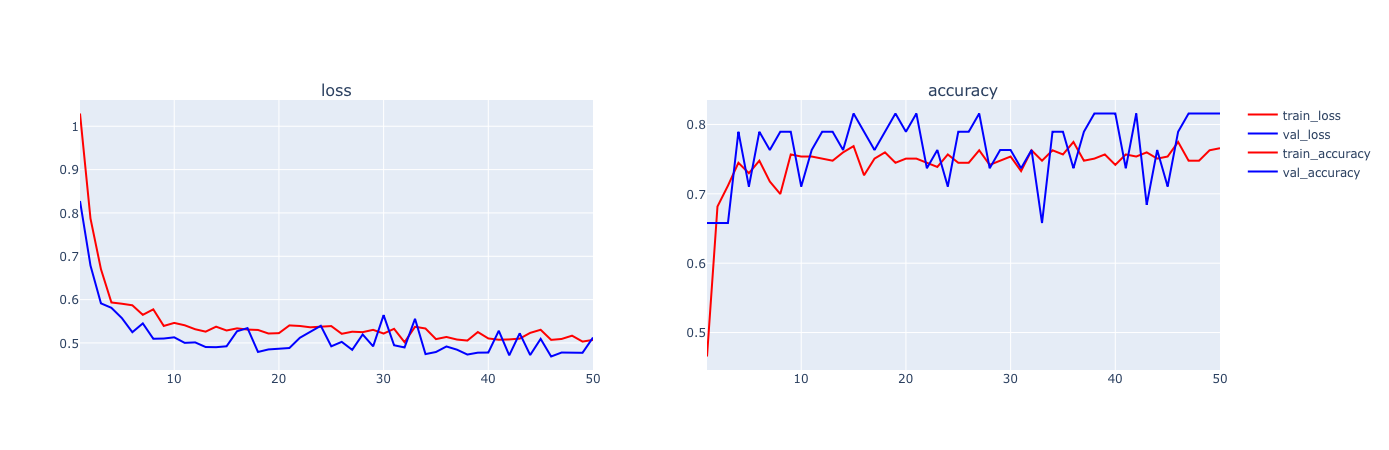

In [39]:
analyze(exproot="/Users/avilay/temp/experiments/ghosts-exp-2", run_name="mute-flower-2063")

In [54]:
df = compare("/Users/avilay/temp/experiments/ghosts-exp-2")

To plot using this dataframe:
fig = go.Figure(layout_title_text='Loss', layout_xaxis_title='Runs'
fig.add_bar(x=summary.run_names, y=summary.val_loss)



In [56]:
df.sort_values(by="val_accuracy", ascending=False).head()

,run_names,val_loss,val_accuracy,batch_size,n_epochs,lr,classifier
2,little-union-6567,0.509801,0.842105,16,50,0.005,2
1,ancient-resonance-0395,0.494521,0.815789,16,50,0.005,4
3,spring-sound-5715,0.477367,0.815789,16,50,0.005,5
10,mute-flower-2063,0.512504,0.815789,16,50,0.005,5
0,plain-sunset-2703,0.534866,0.789474,16,50,0.005,2


Train on the full dataset with the params of `little-union-6567`.

In [64]:
exp = StdoutMLExperiment("final")
trainer = tu.Trainer(exp, dataset, valset, [accuracy])
trainer.metrics_log_frequency = 50
# little union params
# hparams = MyHyperparams(batch_size=16, n_epochs=50, lr=0.005, classifier=2)
# spring sound params
hparams = MyHyperparams(batch_size=16, n_epochs=100, lr=0.005, classifier=5)
trainer.train(hparams, build_trainer)
trainer.final_metrics

Starting run shiny-flower-2644
Starting run shiny-flower-2644

Step 50
	train_loss = 0.506
	train_accuracy = 0.760
	val_loss = 0.427
	val_accuracy = 0.763

Summary:
{'evaluation_metrics': {'val_accuracy': 0.789, 'val_loss': 0.368},
 'hyperparams': {'batch_size': 16,
                 'classifier': 5,
                 'lr': 0.005,
                 'n_epochs': 100}}

Step 100
	train_loss = 0.475
	train_accuracy = 0.779
	val_loss = 0.368
	val_accuracy = 0.789


{'val_loss': 0.36782681941986084, 'val_accuracy': 0.7894736842105263}

# Evaluate on Testset

In [40]:
test_df = pd.read_csv(path.join(DATAROOT, "test.csv"), index_col="id")

In [43]:
testX = test_df[["bone_length", "rotting_flesh", "hair_length", "has_soul"]].values
testX.shape

(529, 4)

In [44]:
testX = t.from_numpy(testX).to(t.float32)

In [65]:
# model = t.load("./little-union-6567.pkl")
model = trainer.model

In [66]:
testy_hat = model(testX)
testy_pred = t.argmax(testy_hat, dim=1)
test_type = type_encoder.inverse_transform(testy_pred.detach())

In [67]:
test_df["type"] = test_type

In [68]:
test_df.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
id,,,,,,
3,0.471774,0.387937,0.706087,0.698537,black,Ghoul
6,0.427332,0.645024,0.565558,0.451462,white,Goblin
9,0.549602,0.491931,0.660387,0.449809,black,Ghoul
10,0.638095,0.682867,0.471409,0.356924,white,Goblin
13,0.361762,0.583997,0.377256,0.276364,black,Ghost


In [69]:
test_df[["type"]].to_csv("/Users/avilay/mldata/ghosts/submission5.csv")